<a href="https://colab.research.google.com/github/DhruvArora96/covid/blob/master/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install langdetect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer, WordNetLemmatizer
import time
import json, requests
from wordcloud import WordCloud
import collections
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist
import pickle
import warnings
import string
import wordcloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

%matplotlib inline


     |████████████████████████████████| 983kB 5.0MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=48c8c0eb7c12fa93ceea397b588212a2a5875aef1e8784668c60c95a516e82e4
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
from google.colab import files
!pip install -q kaggle
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir .kaggle
!mv .kaggle /root/
!mv kaggle.json /root/.kaggle
!kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge
!unzip /content/CORD-19-research-challenge.zip

In [0]:
metadata_df = pd.read_csv("metadata.csv", header = 0)
metadata_df = metadata_df.drop(["sha","pmcid","doi","pubmed_id","Microsoft Academic Paper ID","WHO #Covidence"], axis=1)

# Preprocess Metadata

In [0]:
def textNormalize(rawString):
    if rawString == np.nan:
        return rawString    
    #lowercase all words
    rawString=rawString.lower()
    #remove punctuation
    rawString= rawString.translate(str.maketrans('', '', string.punctuation))
    ## Tokenize
    words = word_tokenize(rawString)
    ## Remove stop words
    nltk_stop_words = stopwords.words('english')
    words = [word for word in words if word not in nltk_stop_words]
    
    ## Stem
    #stemmer = SnowballStemmer('english')
    #words = [stemmer.stem(word) for word in words]
    
    ## Lematize verbs
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    
    normText = " ".join(words)
    
    return normText


In [0]:
#remove non english papers
from langdetect import detect
def detect_language(text):
  try:
    if len(text)>50:
      return detect(text)
    else:
      return np.nan
  except:
    return np.nan

In [0]:
#len(metadata_df["abstract"][15])
metadata_df["language"] = [detect_language(text) for text in metadata_df["abstract"]]
metadata_df=metadata_df.dropna()
#metadata_df=metadata_df.loc[metadata_df["language"]=="en"]
metadata_df["clean_abstract"] = [textNormalize(text) for text in metadata_df["abstract"]]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(metadata_df['clean_abstract'])
# Visualise the 10 most common words

In [0]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
number_topics = 10
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit_transform(count_data)

array([[0.15591699, 0.07027535, 0.00067123, ..., 0.00067128, 0.35475097,
        0.00067128],
       [0.0030309 , 0.35329288, 0.07904658, ..., 0.00303113, 0.00303118,
        0.00303095],
       [0.00588411, 0.16532163, 0.00588416, ..., 0.00588513, 0.00588262,
        0.00588295],
       ...,
       [0.18406292, 0.64125932, 0.00149268, ..., 0.00149296, 0.0014927 ,
        0.00149267],
       [0.00077539, 0.01409949, 0.29043444, ..., 0.00077537, 0.54895588,
        0.00077547],
       [0.00093475, 0.00093472, 0.41245503, ..., 0.00093478, 0.05010822,
        0.25025285]])

In [0]:
n_top_words=10
words = count_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #0:
study merscov case 95 use group result risk ci increase

Topic #1:
sequence virus strain use sample assay viruses gene isolate detect

Topic #2:
cells cell infection immune expression mice response induce viral responses

Topic #3:
health care use public patients study control pandemic result healthcare

Topic #4:
respiratory patients infections children infection viral virus influenza clinical viruses

Topic #5:
calve bovine diarrhea ace2 hcv protein rotavirus membrane intestinal study

Topic #6:
disease diseases model health infectious use new review human data

Topic #7:
vaccine vaccines virus influenza treatment vaccination antibodies antibody use clinical

Topic #8:
use cat dog feline study prrsv plant result group abstract

Topic #9:
virus viral protein proteins viruses rna cells replication host infection


# Generate Wordcloud

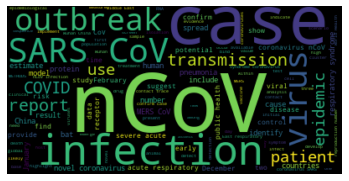

In [0]:
text=(" ").join(metadata.loc[metadata["clean_abstract"].notnull()]["clean_abstract"])
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()